In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.model_selection import validation_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,roc_auc_score,roc_curve,precision_recall_curve,confusion_matrix
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import random
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
import scipy.stats


In [2]:
np.random.seed(42)

# Load data

In [3]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [4]:
train.shape

(614, 13)

In [5]:
test.shape

(367, 12)

In [6]:
train.describe()

ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000

In [7]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [8]:
test.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [9]:
train.head(10)

Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   
5  LP001011   Male     Yes          2      Graduate           Yes   
6  LP001013   Male     Yes          0  Not Graduate            No   
7  LP001014   Male     Yes         3+      Graduate            No   
8  LP001018   Male     Yes          2      Graduate            No   
9  LP001020   Male     Yes          1      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   
5             5417             4196.0       267.0             360.0   
6             2333             1516.0        95.0             360.0   
7             3036             2504.0       158.0             360.0   
8             4006             1526.0       168.0             360.0   
9            12841            10968.0       349.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0         Urban           Y  
3             1.0         Urban           Y  
4             1.0         Urban           Y  
5             1.0         Urban           Y  
6             1.0         Urban           Y  
7             0.0     Semiurban           N  
8             1.0         Urban           Y  
9             1.0     Semiurban           N

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [11]:
train.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [12]:
test.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [13]:
plt.figure(figsize=(10,6))
sns.displot(
    data=train.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)
plt.xlabel("Percent")

Text(0.5, 6.79999999999999, 'Percent')

<Figure size 720x432 with 0 Axes>

Text(0.5, 6.79999999999999, 'Percent')

<Figure size 720x432 with 0 Axes>

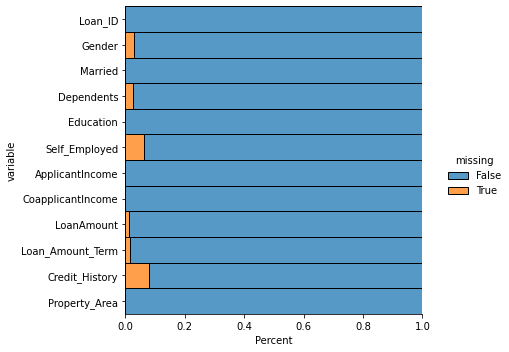

In [14]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.displot(
    data=test.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)
plt.xlabel("Percent")

In [15]:
train=train.drop(['Loan_ID'],axis=1)
test_id = test['Loan_ID']
test=test.drop(['Loan_ID'], axis=1)

# Visualization

<AxesSubplot:xlabel='Dependents', ylabel='count'>

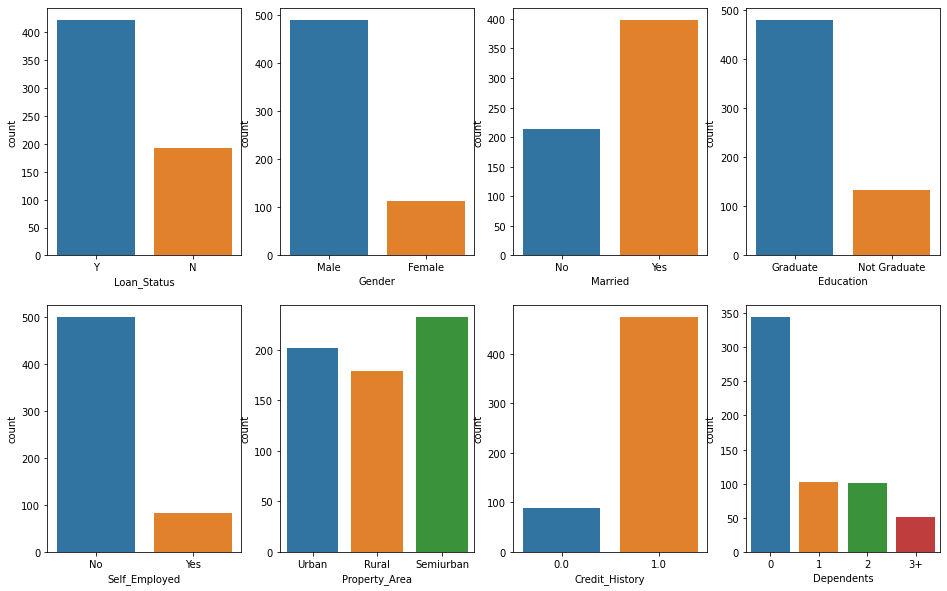

In [16]:
#Univariate Analysis
fig,ax = plt.subplots(2,4,figsize=(16,10))
sns.countplot(x= 'Loan_Status',data=train,ax=ax[0][0])
sns.countplot(x='Gender',data=train,ax=ax[0][1])
sns.countplot(x='Married',data=train,ax=ax[0][2])
sns.countplot(x='Education',data=train,ax=ax[0][3])
sns.countplot(x='Self_Employed',data=train,ax=ax[1][0])
sns.countplot(x='Property_Area',data=train,ax=ax[1][1])
sns.countplot(x='Credit_History',data=train,ax=ax[1][2])
sns.countplot(x='Dependents',data=train,ax=ax[1][3])

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Count'>

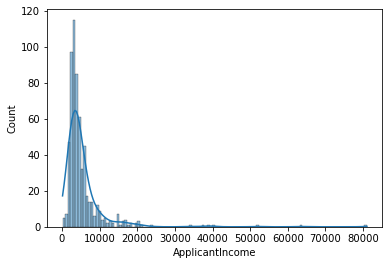

In [17]:
sns.histplot(train["ApplicantIncome"],kde = True)

<AxesSubplot:xlabel='CoapplicantIncome', ylabel='Count'>

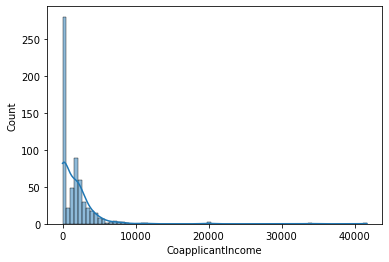

In [18]:
sns.histplot(train["CoapplicantIncome"],kde = True)

<AxesSubplot:xlabel='LoanAmount', ylabel='Count'>

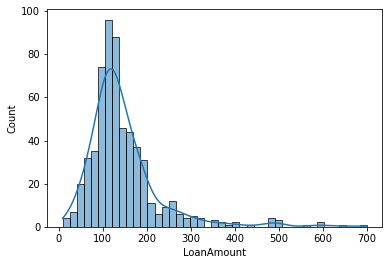

In [19]:
sns.histplot(train["LoanAmount"],kde = True)

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Count'>

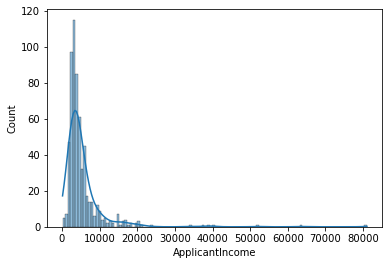

In [20]:
sns.histplot(train['ApplicantIncome'],kde = True)

# Data processing

In [21]:
# fill the missing values for numerical terms - mean
train['LoanAmount'] = train['LoanAmount'].fillna(train['LoanAmount'].mean())

test['LoanAmount'] = test['LoanAmount'].fillna(test['LoanAmount'].mean())


In [22]:
# fill the missing values for categorical terms - mode

train['Gender'] = train["Gender"].fillna(train['Gender'].mode()[0])
train['Married'] = train["Married"].fillna(train['Married'].mode()[0])
train['Dependents'] = train["Dependents"].fillna(train['Dependents'].mode()[0])
train['Self_Employed'] = train["Self_Employed"].fillna(train['Self_Employed'].mode()[0])
train['Credit_History'] = train['Credit_History'].fillna(train['Credit_History'].mode()[0])
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0])


test['Gender'] = test["Gender"].fillna(test['Gender'].mode()[0])
test['Married'] = test["Married"].fillna(test['Married'].mode()[0])
test['Dependents'] = test["Dependents"].fillna(test['Dependents'].mode()[0])
test['Self_Employed'] = test["Self_Employed"].fillna(test['Self_Employed'].mode()[0])
test['Credit_History'] = test['Credit_History'].fillna(test['Credit_History'].mode()[0])
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].mode()[0])


In [23]:
train.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [24]:
converted_features = ["Gender","Married","Education","Self_Employed","Property_Area","Dependents","Credit_History"]
def converted_cat(df, features):
    for feature in features:
        df[feature] = df[feature].astype("category")

converted_cat(train, converted_features)
converted_cat(test, converted_features)

# Feature engineering

#### Tạo feature mới

In [25]:
# combine training and test dataset
combine_set=pd.concat([train,test], ignore_index=True)

In [26]:
# total income
combine_set['Total_Income'] = combine_set['ApplicantIncome'] + combine_set['CoapplicantIncome']
combine_set.head()

Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No          0      Graduate            No             5849   
1   Male     Yes          1      Graduate            No             4583   
2   Male     Yes          0      Graduate           Yes             3000   
3   Male     Yes          0  Not Graduate            No             2583   
4   Male      No          0      Graduate            No             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term Credit_History  \
0                0.0  146.412162             360.0            1.0   
1             1508.0  128.000000             360.0            1.0   
2                0.0   66.000000             360.0            1.0   
3             2358.0  120.000000             360.0            1.0   
4                0.0  141.000000             360.0            1.0   

  Property_Area Loan_Status  Total_Income  
0         Urban           Y        5849.0  
1         Rural           N        6091.0  
2         Urban           Y        3000.0  
3         Urban           Y        4941.0  
4         Urban           Y        6000.0

$$EMI = P * \frac{r(1+r)^{n}}{(1+r)^{n} - 1}$$

In [27]:
r = (8/12)/100
combine_set['EMI'] = combine_set['LoanAmount']*((r*(1+r)**combine_set['Loan_Amount_Term'])) / ((1+r)**combine_set['Loan_Amount_Term'] - 1)
combine_set['LoanAmountTerm_per_TotalIncome'] = combine_set['LoanAmount'] / combine_set['Total_Income']
combine_set['EMI_per_TotalIncome'] = combine_set['EMI'] / combine_set['Total_Income']
combine_set['EMI_per_LoanAmount'] = combine_set['EMI'] / combine_set['LoanAmount']
combine_set['EMI_per_LoanAmountTerm'] = combine_set['EMI'] / combine_set['Loan_Amount_Term']

<AxesSubplot:>

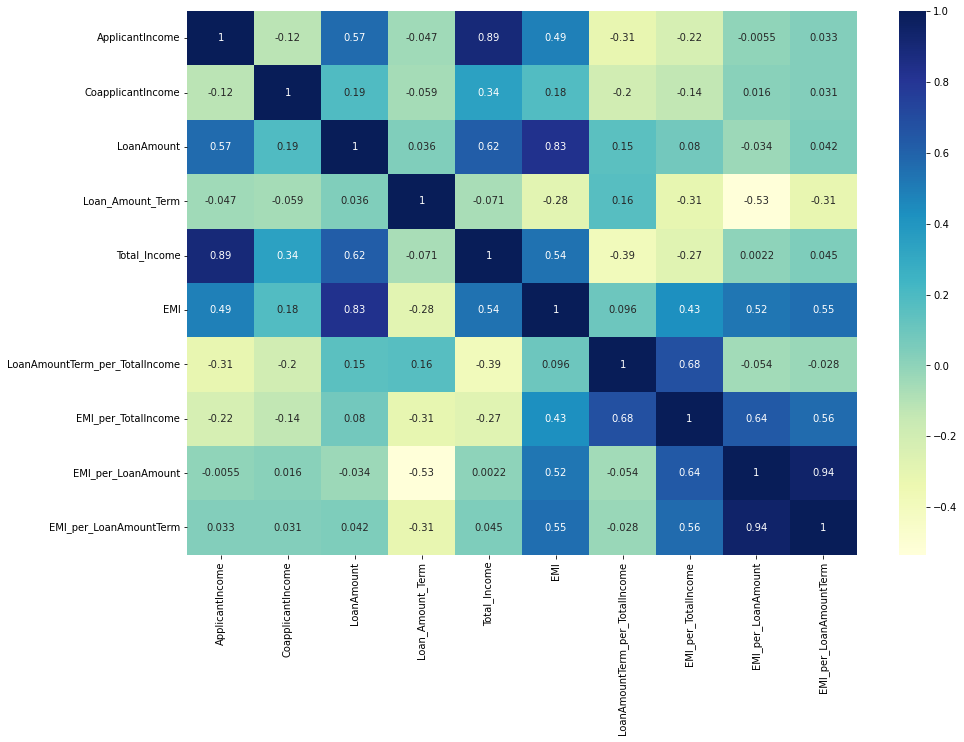

In [28]:
#Corelation Matrix
corr = combine_set[combine_set['Loan_Status'].isnull()==False].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot = True, cmap="YlGnBu")

In [29]:
# Label encode categorical variables
from sklearn.preprocessing import LabelEncoder
cols = ["Gender","Married","Education",'Self_Employed',"Property_Area","Dependents","Credit_History"]
le = LabelEncoder()
for col in cols:
    combine_set[col] = le.fit_transform(combine_set[col])

In [30]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
cols = ["LoanAmount","Loan_Amount_Term","LoanAmountTerm_per_TotalIncome","EMI_per_TotalIncome","EMI_per_LoanAmount", "EMI_per_LoanAmountTerm","ApplicantIncome","CoapplicantIncome","EMI","Total_Income"]
sd = StandardScaler()
for col in cols:
    combine_set[col] = sd.fit_transform(combine_set[col].values.reshape(-1,1))

In [31]:
combine_set[combine_set['Loan_Status'].isnull()==False]

Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0         1        0           0          0              0         0.117565   
1         1        1           1          0              0        -0.104844   
2         1        1           0          0              1        -0.382944   
3         1        1           0          1              0        -0.456202   
4         1        0           0          0              0         0.144093   
..      ...      ...         ...        ...            ...              ...   
609       0        0           0          0              0        -0.400512   
610       1        1           3          0              0        -0.188643   
611       1        1           1          0              0         0.508100   
612       1        1           2          0              0         0.422193   
613       0        0           0          0              1        -0.104844   

     CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0            -0.589506    0.050394          0.270528               1   
1            -0.034561   -0.190880          0.270528               1   
2            -0.589506   -1.003329          0.270528               1   
3             0.278239   -0.295712          0.270528               1   
4            -0.589506   -0.020527          0.270528               1   
..                 ...         ...               ...             ...   
609          -0.589506   -0.937809          0.270528               1   
610          -0.589506   -1.344034         -2.522372               1   
611          -0.501186    1.447124          0.270528               1   
612          -0.589506    0.582258          0.270528               1   
613          -0.589506   -0.125360          0.270528               0   

     Property_Area Loan_Status  Total_Income       EMI  \
0                2           Y     -0.154913 -0.056339   
1                0           N     -0.114719 -0.182096   
2                2           Y     -0.628099 -0.605563   
3                2           Y     -0.305721 -0.236737   
4                2           Y     -0.129833 -0.093304   
..             ...         ...           ...       ...   
609              0           Y     -0.644708 -0.571413   
610              0           Y     -0.444405 -0.700530   
611              2           Y      0.254164  0.671669   
612              2           Y      0.133085  0.220881   
613              1           N     -0.365181 -0.147945   

     LoanAmountTerm_per_TotalIncome  EMI_per_TotalIncome  EMI_per_LoanAmount  \
0                          0.093717            -0.052438           -0.103376   
1                         -0.344574            -0.258894           -0.103376   
2                         -0.237069            -0.208254           -0.103376   
3                          0.012393            -0.090745           -0.103376   
4                         -0.073422            -0.131168           -0.103376   
..                              ...                  ...                 ...   
609                        0.033796            -0.080664           -0.103376   
610                       -1.574418            -0.686816            0.235637   
611                        0.683496             0.225375           -0.103376   
612                        0.053179            -0.071533           -0.103376   
613                        0.528835             0.152522           -0.103376   

     EMI_per_LoanAmountTerm  
0                 -0.058334  
1                 -0.061805  
2                 -0.073492  
3                 -0.063313  
4                 -0.059354  
..                      ...  
609               -0.072550  
610               -0.066293  
611               -0.038241  
612               -0.050683  
613               -0.060862  

[614 rows x 18 columns]

In [32]:
train_df=combine_set[combine_set['Loan_Status'].isnull()==False]
test_df=combine_set[combine_set['Loan_Status'].isnull()==True]

In [33]:
# specify input and output attributes
train_df['Loan_Status'] = train_df['Loan_Status'].apply(lambda x: 1 if x == "Y" else 0)
X = train_df.drop(columns=['Loan_Status'], axis=1)
y = train_df['Loan_Status']

# drop target column (which is blank) from test dataset
test =test_df.drop(['Loan_Status'],axis=1)

C:\Users\quypr\AppData\Local\Temp/ipykernel_15616/3963069098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Loan_Status'] = train_df['Loan_Status'].apply(lambda x: 1 if x == "Y" else 0)


#### Feature important (dùng random forest)

In [34]:
rdf_clf = RandomForestClassifier()
rdf_clf.fit(("Loan_Amount_Term"),y)

RandomForestClassifier()

In [35]:
rdf_clf.feature_names_in_

array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Total_Income', 'EMI', 'LoanAmountTerm_per_TotalIncome',
       'EMI_per_TotalIncome', 'EMI_per_LoanAmount',
       'EMI_per_LoanAmountTerm'], dtype=object)

In [36]:
np.argsort(rdf_clf.feature_importances_)[::-1]

array([ 9, 13, 11,  5, 14, 16, 12,  7,  6, 10,  2,  8,  1, 15,  3,  0,  4],
      dtype=int64)

In [37]:
rdf_clf.feature_importances_

array([0.01068149, 0.01339583, 0.02156677, 0.0127158 , 0.0103001 ,
       0.08813343, 0.0528008 , 0.06577678, 0.01409456, 0.25589886,
       0.02872633, 0.08943689, 0.06741217, 0.10262824, 0.08502892,
       0.01301505, 0.06838798])

In [38]:
name = []
value = []

In [39]:
for idx in (np.argsort(rdf_clf.feature_importances_)[::-1]):
    name.append(rdf_clf.feature_names_in_[idx])
    value.append(rdf_clf.feature_importances_[idx] )
    print(rdf_clf.feature_names_in_[idx] , ": " , rdf_clf.feature_importances_[idx] )

Credit_History :  0.25589885649661775
LoanAmountTerm_per_TotalIncome :  0.10262823707635059
Total_Income :  0.08943689301618903
ApplicantIncome :  0.08813343392300783
EMI_per_TotalIncome :  0.085028919988377
EMI_per_LoanAmountTerm :  0.06838797846034174
EMI :  0.06741216714409139
LoanAmount :  0.06577677731623262
CoapplicantIncome :  0.05280080330723115
Property_Area :  0.028726328639176017
Dependents :  0.021566765077386932
Loan_Amount_Term :  0.01409456231767058
Married :  0.013395834248768028
EMI_per_LoanAmount :  0.01301505319532536
Education :  0.012715800758586894
Gender :  0.010681492485460542
Self_Employed :  0.010300096549186726


In [40]:
p = pd.DataFrame({"Value":value},index=name,).reset_index()
p

index     Value
0                   Credit_History  0.255899
1   LoanAmountTerm_per_TotalIncome  0.102628
2                     Total_Income  0.089437
3                  ApplicantIncome  0.088133
4              EMI_per_TotalIncome  0.085029
5           EMI_per_LoanAmountTerm  0.068388
6                              EMI  0.067412
7                       LoanAmount  0.065777
8                CoapplicantIncome  0.052801
9                    Property_Area  0.028726
10                      Dependents  0.021567
11                Loan_Amount_Term  0.014095
12                         Married  0.013396
13              EMI_per_LoanAmount  0.013015
14                       Education  0.012716
15                          Gender  0.010681
16                   Self_Employed  0.010300

Text(0.5, 0, 'Ranking')

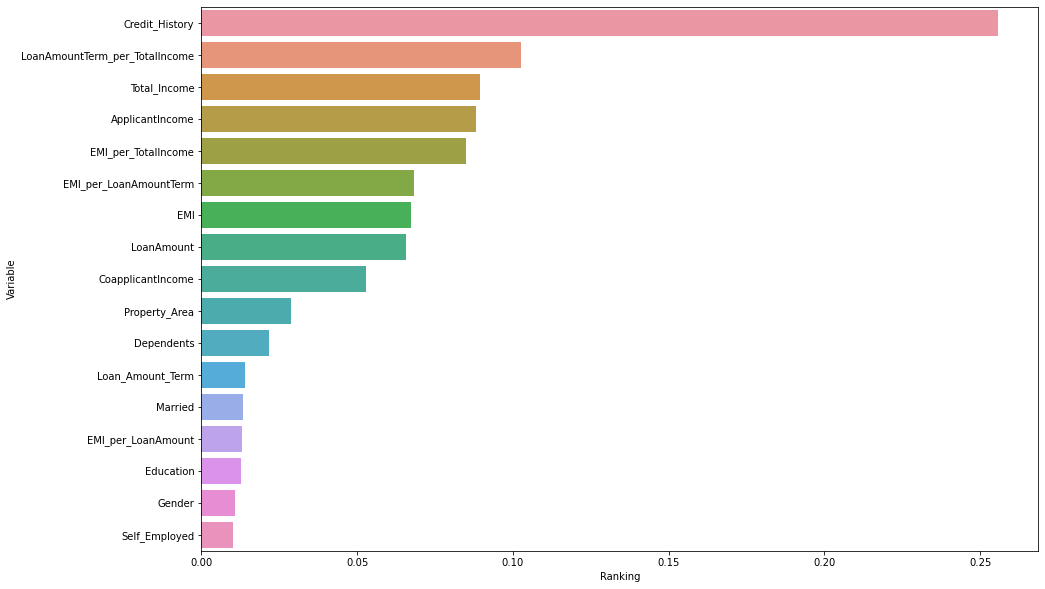

In [41]:
plt.figure(figsize = (15,10))
sns.barplot(data = p,x = 'Value',y='index')
plt.ylabel("Variable")
plt.xlabel("Ranking")

In [42]:
for idx in np.argpartition(rdf_clf.feature_importances_,-9)[::-1][:9]:
    print(rdf_clf.feature_names_in_[idx] , ": " , rdf_clf.feature_importances_[idx] )

Total_Income :  0.08943689301618903
ApplicantIncome :  0.08813343392300783
EMI_per_TotalIncome :  0.085028919988377
LoanAmountTerm_per_TotalIncome :  0.10262823707635059
Credit_History :  0.25589885649661775
EMI_per_LoanAmountTerm :  0.06838797846034174
EMI :  0.06741216714409139
LoanAmount :  0.06577677731623262
CoapplicantIncome :  0.05280080330723115


In [43]:
rdf_clf.feature_names_in_[np.argpartition(rdf_clf.feature_importances_,-9)[::-1][:9]]

array(['Total_Income', 'ApplicantIncome', 'EMI_per_TotalIncome',
       'LoanAmountTerm_per_TotalIncome', 'Credit_History',
       'EMI_per_LoanAmountTerm', 'EMI', 'LoanAmount', 'CoapplicantIncome'],
      dtype=object)

In [44]:
X = X[rdf_clf.feature_names_in_[np.argpartition(rdf_clf.feature_importances_,-9)[::-1][:9]]]

In [45]:
X.head(5)

Total_Income  ApplicantIncome  EMI_per_TotalIncome  \
0     -0.154913         0.117565            -0.052438   
1     -0.114719        -0.104844            -0.258894   
2     -0.628099        -0.382944            -0.208254   
3     -0.305721        -0.456202            -0.090745   
4     -0.129833         0.144093            -0.131168   

   LoanAmountTerm_per_TotalIncome  Credit_History  EMI_per_LoanAmountTerm  \
0                        0.093717               1               -0.058334   
1                       -0.344574               1               -0.061805   
2                       -0.237069               1               -0.073492   
3                        0.012393               1               -0.063313   
4                       -0.073422               1               -0.059354   

        EMI  LoanAmount  CoapplicantIncome  
0 -0.056339    0.050394          -0.589506  
1 -0.182096   -0.190880          -0.034561  
2 -0.605563   -1.003329          -0.589506  
3 -0.236737   -0.295712           0.278239  
4 -0.093304   -0.020527          -0.589506

#### Split data

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model

In [47]:
models = [LogisticRegression(),SGDClassifier(),RandomForestClassifier(),KNeighborsClassifier(),SVC(),DecisionTreeClassifier(),ExtraTreesClassifier(),GradientBoostingClassifier(),XGBClassifier()]
model_score = {}

for model in models:
    score = cross_val_score(model,x_train,y_train,cv = 5,scoring = 'accuracy')
    model_score[type(model).__name__] = score


In [48]:
models_accu = [LogisticRegression(),SGDClassifier(),RandomForestClassifier(),KNeighborsClassifier(),SVC(),DecisionTreeClassifier(),ExtraTreesClassifier(),GradientBoostingClassifier(),XGBClassifier()]
model_score_accu = {}

for model in models_accu:
    model.fit(x_train,y_train)
    score = accuracy_score(y_test,model.predict(x_test))
    model_score_accu[type(model).__name__] = score


In [49]:
for key,value in model_score_accu.items():
    print(key + ": " + str(value*100))

LogisticRegression: 78.04878048780488
SGDClassifier: 77.23577235772358
RandomForestClassifier: 78.04878048780488
KNeighborsClassifier: 79.67479674796748
SVC: 80.48780487804879
DecisionTreeClassifier: 78.04878048780488
ExtraTreesClassifier: 78.86178861788618
GradientBoostingClassifier: 77.23577235772358
XGBClassifier: 78.86178861788618


In [50]:
models_f1 = [LogisticRegression(),SGDClassifier(),RandomForestClassifier(),KNeighborsClassifier(),SVC(),DecisionTreeClassifier(),ExtraTreesClassifier(),GradientBoostingClassifier(),XGBClassifier()]
model_score_f1 = {}

for model in models_f1:
    model.fit(x_train,y_train)
    score = f1_score(y_test,model.predict(x_test))
    model_score_f1[type(model).__name__] = score


In [51]:
for key,value in model_score_f1.items():
    print(key + ": " + str(value*100))

LogisticRegression: 85.24590163934427
SGDClassifier: 85.87570621468925
RandomForestClassifier: 85.0574712643678
KNeighborsClassifier: 85.71428571428572
SVC: 86.81318681318682
DecisionTreeClassifier: 81.98757763975155
ExtraTreesClassifier: 85.71428571428572
GradientBoostingClassifier: 83.42857142857143
XGBClassifier: 85.22727272727273


In [52]:
pd.DataFrame(model_score)

LogisticRegression  SGDClassifier  RandomForestClassifier  \
0            0.828283       0.808081                0.828283   
1            0.816327       0.693878                0.755102   
2            0.816327       0.744898                0.795918   
3            0.795918       0.724490                0.755102   
4            0.816327       0.612245                0.775510   

   KNeighborsClassifier       SVC  DecisionTreeClassifier  \
0              0.808081  0.818182                0.757576   
1              0.785714  0.795918                0.714286   
2              0.785714  0.806122                0.755102   
3              0.785714  0.785714                0.704082   
4              0.755102  0.806122                0.714286   

   ExtraTreesClassifier  GradientBoostingClassifier  XGBClassifier  
0              0.838384                    0.828283       0.828283  
1              0.734694                    0.755102       0.744898  
2              0.755102                    0.816327       0.795918  
3              0.755102                    0.775510       0.744898  
4              0.806122                    0.795918       0.755102

In [53]:
def anova(scores):
    mean = 0
    for i in range(len(scores)):
        mean += scores[i].mean()
    mean /= len(scores)
    SSA = 0
    SSE = 0

    for i in range(len(scores)):
        SSA += 5*(mean - scores[i].mean())**2 
        SSE += sum((scores[i].mean() - scores[i])**2) 
    dfr = len(scores)*len(scores[0]) - len(scores) 
    MSA = SSA / (len(scores) - 1)
    MSE = SSE / dfr
    F = MSA / MSE
    print("--------------------------------------------------------------------------------")
    print ("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20} ".format('Source','df','SS',"MS","F","P-value"))
    print ("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20} ".format('Display',len(scores) - 1,SSA.round(10),MSA.round(10),F.round(10),scipy.stats.f.sf(abs(F),len(scores) - 1,dfr)))
    print ("{:<20} {:<20} {:<20} {:<20} ".format('Residuals',dfr,SSE.round(7),MSE.round(7)))

* $H_0 : \mu_1 = \mu_2 = ... = \mu_8$
* $H_1 : \mu_1 \neq \mu_2 = ... \neq \mu_8$


Với $\alpha = 0.05$

In [54]:
anova([model_score["LogisticRegression"],model_score["SGDClassifier"],model_score['RandomForestClassifier'],model_score['SVC'],model_score['DecisionTreeClassifier'],model_score['ExtraTreesClassifier'],model_score['GradientBoostingClassifier'],model_score['XGBClassifier']])

--------------------------------------------------------------------------------
Source               df                   SS                   MS                   F                    P-value              
Display              7                    0.041232915          0.0058904164         4.2331259541         0.0020919212295060162 
Residuals            32                   0.0445282            0.0013915            


vì P-value = 0.02184 < $\alpha = 0.05$ nên bác bỏ $H_0$. Vậy có sự khác nhau giữa các mô hình

<AxesSubplot:>

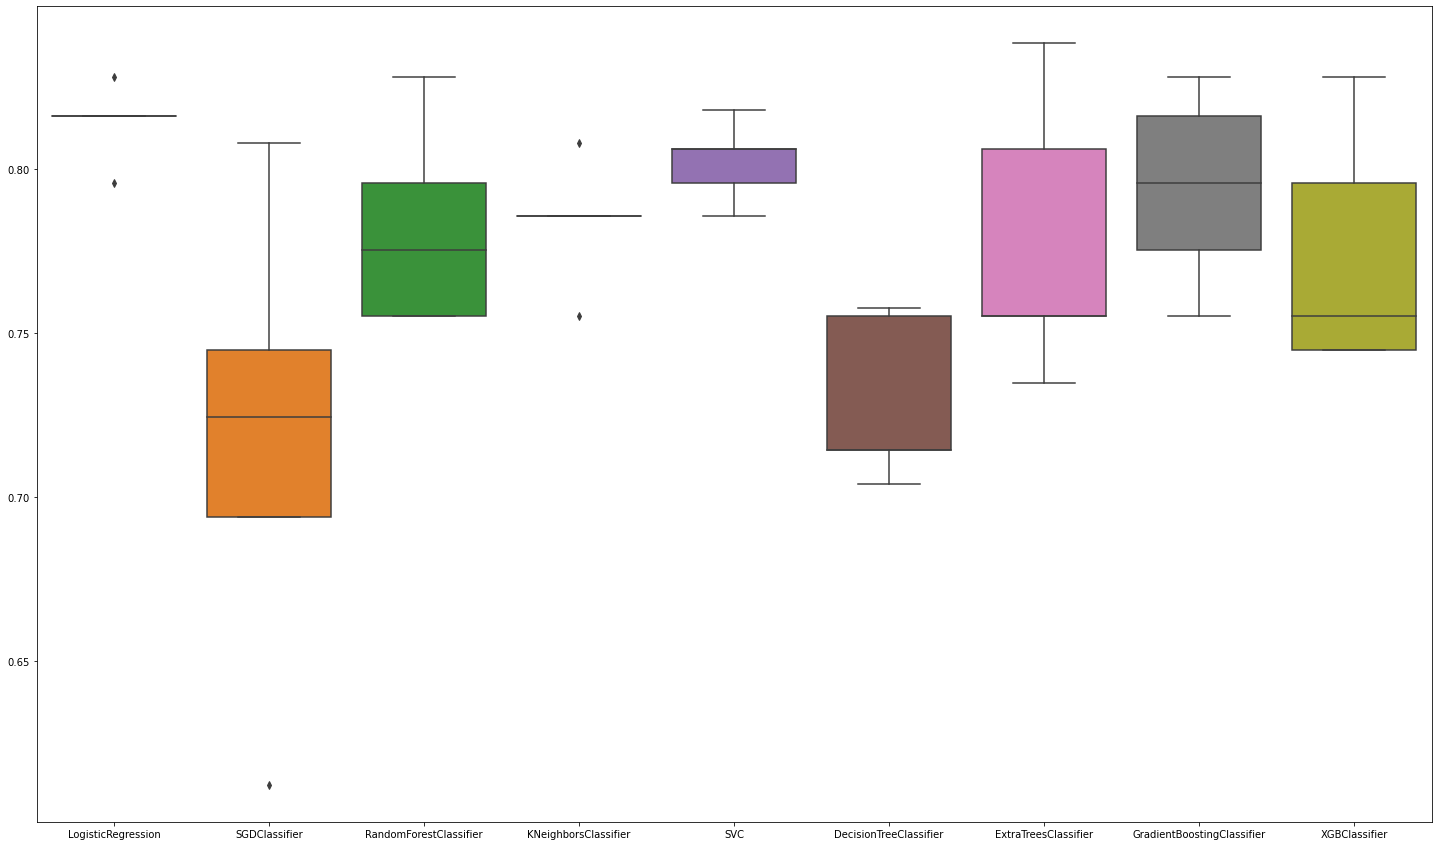

In [55]:
plt.figure(figsize = (25,15))
sns.boxplot(data = pd.DataFrame(model_score))

# Thử nghiệm các mô hình khác nhau

## Thử nghiệm trên mô hình Logistic Regression

In [56]:
log_clf = LogisticRegression()
log_clf.fit(x_train,y_train)

LogisticRegression()

In [57]:
y_score = cross_val_predict(log_clf,x_train,y_train,cv =3 ,method= 'decision_function')

In [58]:
confusion_matrix(y_train,log_clf.predict(x_train))

array([[ 70,  79],
       [  7, 335]], dtype=int64)

In [59]:
precision, recall, threshold = precision_recall_curve(y_train,y_score)  

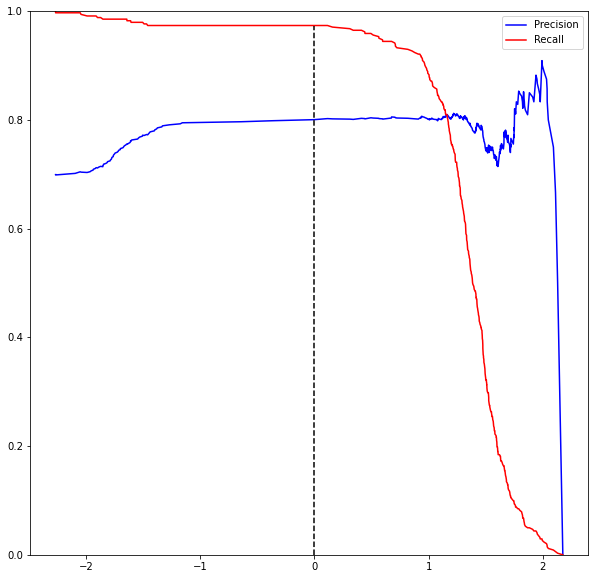

In [60]:
plt.figure(figsize = (10,10))
plt.plot(threshold,precision[:-1],'b-',label = 'Precision')
plt.plot(threshold,recall[:-1],'r-',label = 'Recall')
plt.ylim([0,1])
plt.plot([threshold[np.argmax(precision >= 0.8)],threshold[np.argmax(precision >= 0.8)]],[0,recall[np.argmax(precision >= 0.8)]],'k--')
plt.legend()

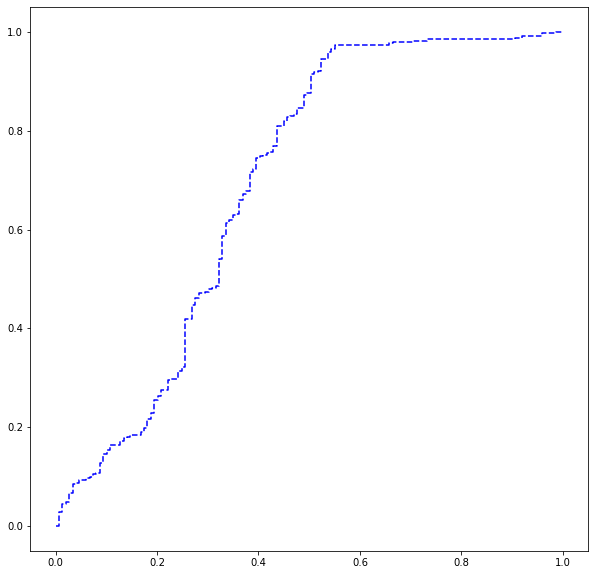

In [61]:
fpr,tpr,threshold_roc = roc_curve(y_train,y_score)
plt.figure(figsize = (10,10))

plt.plot(fpr,tpr,'b--')

In [62]:
y_pred = y_score >= threshold[np.argmax(precision >= 0.78)]

In [63]:
accuracy_score(y_train == 1,y_pred)

0.7922606924643585

In [64]:
f1_score(y_train == 1,y_pred)

0.8671875

In [65]:
precision_score(y_train == 1,y_pred)

0.7816901408450704

In [66]:
recall_score(y_train == 1,y_pred)

0.9736842105263158

In [67]:
confusion_matrix(y_train==1,y_pred)

array([[ 56,  93],
       [  9, 333]], dtype=int64)

### Tìm kiếm tham số cho mô hình Logistic Regression 

In [68]:
param_grid = [
    {
        "penalty": ['l2','l1'],
        "C": np.linspace(1e-6,1,100),
        'solver': ['liblinear'],

    },
    {
        "penalty": ['l2'],
        "C": np.linspace(1e-6,1,100),
        'solver': ['lbfgs'],
    },

    {
        "penalty": ['elasticnet'],
        "C": np.linspace(1e-6,1,100),
        'l1_ratio' : np.linspace(0,1,20),
        'solver': ['saga'],
        'max_iter' : [5000],
    },
    
]

In [69]:
grid_search = GridSearchCV(log_clf,param_grid,scoring='accuracy',cv=5,verbose = 3)

In [70]:
# grid_search.fit(x_train,y_train)

In [71]:
# grid_search.best_params_

In [72]:
best_logis = {'C': 0.09090999999999999, 'penalty': 'l2', 'solver': 'lbfgs'}

In [73]:
log_clf = LogisticRegression()
log_clf.fit(x_train,y_train)

LogisticRegression()

In [74]:
log_improve = LogisticRegression(random_state=42,**best_logis)
log_improve.fit(x_train,y_train)

LogisticRegression(C=0.09090999999999999, random_state=42)

In [75]:
cross_val_score(log_clf,x_train,y_train,cv=5).mean()

0.8146361574933003

In [76]:
log_score = cross_val_score(log_improve,x_train,y_train,cv=20)
log_score.mean()

0.8166666666666668

## Thử nghiệm trên mô hình SGDC

In [77]:
sgdc = SGDClassifier(random_state=42)
sgdc.fit(x_train,y_train)

SGDClassifier(random_state=42)

In [78]:
cross_val_score(sgdc,x_train,y_train,cv=5).mean()

0.7841888270459699

### Tìm kiếm tham số cho mô hình SGDC

In [79]:
param_grid_sgdc = [
    {
        'alpha': np.linspace(1e-5,1e-2,500),
        'learning_rate' : ['constant','optimal'],
        'eta0' :np.linspace(0.00001,0.1,20),
        'loss': ['hinge']
    },    
]

In [80]:
grid_search_sgdc = GridSearchCV(sgdc,param_grid_sgdc,cv = 5,scoring='accuracy',verbose = 3)

In [81]:
# grid_search_sgdc.fit(x_train,y_train)

In [82]:
# grid_search_sgdc.best_params_

In [83]:
best_sgdc ={'alpha': 1e-05,
 'eta0': 0.005272631578947368,
 'learning_rate': 'constant',
 'loss': 'hinge'}

In [84]:
sgdc_improve = SGDClassifier(random_state=42,**best_sgdc)
sgdc_improve.fit(x_train,y_train)

SGDClassifier(alpha=1e-05, eta0=0.005272631578947368, learning_rate='constant',
              random_state=42)

In [85]:
sgdc_score = cross_val_score(sgdc_improve,x_train,y_train,cv=20)
sgdc_score.mean()

0.8145

## Thử nghiệm trên mô hình SVC

In [86]:
svc = SVC()
svc.fit(x_train,y_train)

SVC()

In [87]:
cross_val_score(svc,x_train,y_train,cv=5).mean()

0.8024118738404452

### Tìm kiếm tham số cho mô hình SVC

In [88]:
param_grid_svc = [
    {
        "C" : np.linspace(1,100,200),
        'kernel' : ['poly'],
        'degree' : [1,2,3], 
        'coef0' : [0,0.1,0.01,0.001,0.0001] 
    },
    {
        "C" : np.linspace(1,100,200),
        'kernel' : ['rbf'],
        'gamma': np.linspace(1,10,100)
    },

]

In [89]:
grid_search_svc= GridSearchCV(svc,param_grid_svc,cv = 5,scoring='accuracy',verbose = 3)

In [90]:
# grid_search_svc.fit(x_train,y_train)

In [91]:
# grid_search_svc.best_params_

In [92]:
best_svc = {'C': 1.0, 'coef0': 0, 'degree': 1, 'kernel': 'poly'}

In [93]:
svc_improve = SVC(random_state=42,probability=True,**best_svc)
svc_improve.fit(x_train,y_train)

SVC(coef0=0, degree=1, kernel='poly', probability=True, random_state=42)

In [94]:
svc_improve.score(x_test,y_test)

0.7886178861788617

In [95]:
svc_score = cross_val_score(svc_improve,x_train,y_train,cv=20)
svc_score.mean()

0.8145

In [96]:
f1_score(y_test,svc_improve.predict(x_test))

0.8586956521739131

## Thử nghiệm trên mô hình Decision Tree

In [97]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train,y_train)

DecisionTreeClassifier(random_state=42)

In [98]:
cross_val_score(tree,x_train,y_train,cv=5).mean()

0.7290455576169862

### Tìm kiếm tham số cho mô hình Decision Tree

In [99]:
param_grid_tree = [
    {
        "criterion" : ['gini',"entropy"],
        "splitter": ['best','random'],
        'max_depth': np.linspace(1,5,5).astype(int),
        'min_samples_split' : np.linspace(2,10,9).astype(int), 
        'min_samples_leaf' : np.linspace(2,10,9).astype(int),
        'max_leaf_nodes': np.linspace(2,10,9).astype(int),
    }
]

In [100]:
grid_search_tree= GridSearchCV(tree,param_grid_tree,cv = 5,scoring='accuracy',verbose = 3)

In [101]:
# grid_search_tree.fit(x_train,y_train)

In [102]:
# grid_search_tree.best_params_

In [103]:
best_tree = {'criterion': 'gini',
 'max_depth': 4,
 'max_leaf_nodes': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'splitter': 'best'}

In [104]:
tree_improve = DecisionTreeClassifier(random_state=42,**best_tree)
tree_improve.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=7, min_samples_leaf=2,
                       random_state=42)

In [105]:
tree_score = cross_val_score(tree_improve,x_train,y_train,cv=20)
tree_score.mean()

0.8167500000000001

In [106]:
cross_val_score(tree_improve,x_train,y_train,cv=20,scoring = 'f1')

array([0.82051282, 0.91891892, 0.91891892, 0.94444444, 0.82926829,
       0.8       , 0.86486486, 0.86486486, 0.89473684, 0.94444444,
       0.84210526, 0.96969697, 0.82926829, 0.81081081, 0.88888889,
       0.89473684, 0.97142857, 0.84210526, 0.89473684, 0.87179487])

## So sánh sự khác nhau giữa 2 mô hình ExtraTree và RandomForest

### Extra Tree

In [107]:
extra_tree = ExtraTreesClassifier(random_state=42)
extra_tree.fit(x_train,y_train)

ExtraTreesClassifier(random_state=42)

In [108]:
cross_val_score(extra_tree,x_train,y_train,cv=5).mean()

0.7819624819624819

#### Tìm kiếm tham số cho mô hình Extra Tree

In [109]:
param_grid_extratree = [
    {
        "criterion" : ['gini',"entropy"],
        'max_depth': np.linspace(2,6,5).astype(int),
        'min_samples_split' : np.linspace(2,10,9).astype(int), 
        'min_samples_leaf' : np.linspace(2,10,9).astype(int),
        'max_leaf_nodes': np.linspace(2,10,9).astype(int),
    }
]

In [110]:
grid_search_extratree= GridSearchCV(extra_tree,param_grid_extratree,cv = 5,scoring='accuracy',verbose = 3)

In [111]:
# grid_search_extratree.fit(x_train,y_train)

In [112]:
# grid_search_extratree.best_params_

In [113]:
best_extratree = {'criterion': 'gini',
 'max_depth': 5,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [114]:
extra_tree_improve = ExtraTreesClassifier(random_state=42,**best_extratree)
extra_tree_improve.fit(x_train,y_train)

ExtraTreesClassifier(max_depth=5, max_leaf_nodes=10, min_samples_leaf=2,
                     min_samples_split=5, random_state=42)

In [115]:
extratree_score = cross_val_score(extra_tree_improve,x_train,y_train,cv=20)
extratree_score.mean()

0.8186666666666668

### Random Forest

In [116]:
rdf = RandomForestClassifier(random_state=42)
rdf.fit(x_train,y_train)

RandomForestClassifier(random_state=42)

In [117]:
cross_val_score(rdf,x_train,y_train,cv=5).mean()

0.7901051329622759

#### Tìm kiếm tham số cho mô hình Random Forest

In [118]:
param_grid_rdf = [
    {
        "criterion" : ['gini',"entropy"],
        'max_depth': np.linspace(2,6,5).astype(int),
        'min_samples_split' : np.linspace(2,10,9).astype(int), 
        'min_samples_leaf' : np.linspace(2,10,9).astype(int),
        'max_leaf_nodes': np.linspace(2,10,9).astype(int),
    }
]

In [119]:
grid_search_rdf= GridSearchCV(rdf,param_grid_rdf,cv = 5,scoring='accuracy',verbose = 3)

In [120]:
# grid_search_rdf.fit(x_train,y_train)

In [121]:
# grid_search_rdf.best_params_

In [122]:
best_rdf = {'criterion': 'gini',
 'max_depth': 3,
 'max_leaf_nodes': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [123]:
rdf_improve = RandomForestClassifier(random_state=42,**best_rdf)
rdf_improve.fit(x_train,y_train)

RandomForestClassifier(max_depth=3, max_leaf_nodes=5, min_samples_leaf=4,
                       random_state=42)

In [124]:
rdf_score = cross_val_score(rdf_improve,x_train,y_train,cv=20)
rdf_score.mean()

0.8185833333333334

Random Forest tốt hơn ExtraTree

## Boosting

### Gradient Boosting

In [125]:
grad_boost = GradientBoostingClassifier(learning_rate=0.05,random_state=42,max_depth=2,min_samples_split = 2,min_samples_leaf = 2,subsample=0.5)
grad_boost.fit(x_train,y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=2, min_samples_leaf=2,
                           random_state=42, subsample=0.5)

In [126]:
grad_boost.score(x_test,y_test)

0.8048780487804879

In [127]:
gradboost_score = cross_val_score(grad_boost,x_train,y_train,cv=20)
gradboost_score.mean()

0.8125000000000002

### Extreme Gradient Boosting

#### Tìm kiếm tham số cho mô hình XGBC

In [128]:
space={
    'eta': hp.quniform("eta", 0.01,0.09,0.01),
    'max_depth': hp.choice("max_depth", np.arange(2, 10, dtype=int)),
        'gamma': hp.choice ('gamma', np.arange(1, 10, dtype=int)),
        'reg_alpha' : hp.choice('reg_alpha', np.arange(1, 5, dtype=int)),
        'reg_lambda' : hp.choice('reg_lambda', np.arange(1, 5, dtype=int)),
        'colsample_bytree' : hp.uniform("colsample_bytree",0.5,1.0),
        'min_child_weight' : hp.choice('min_child_weight', np.arange(1, 10)),
        'n_estimators': 150,
    }


In [129]:
def objective(space):
    clf=XGBClassifier(
                    eta = space['eta'],tree_method = "exact",objective="binary:logistic",
                    n_estimators =space['n_estimators'], max_depth = (space['max_depth']), gamma = space['gamma'],
                    reg_alpha = (space['reg_alpha']),min_child_weight=(space['min_child_weight']),
                    colsample_bytree=(space['colsample_bytree']),use_label_encoder=False,eval_metric="error",early_stopping_rounds = 100,seed = 42)
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation,
            verbose=False)
    

    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }
objective(space)

SCORE: 0.8048780487804879


{'loss': -0.8048780487804879, 'status': 'ok'}

In [130]:
# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)


In [131]:
# best_hyperparams

In [132]:
best = {'colsample_bytree': 0.7328996377661416,
 'eta': 0.03,
 'gamma': 2,
 'max_depth': 4,
 'min_child_weight': 2,
 'reg_alpha': 2,
 'reg_lambda': 3,
    'n_estimators': 150,
}
best

{'colsample_bytree': 0.7328996377661416,
 'eta': 0.03,
 'gamma': 2,
 'max_depth': 4,
 'min_child_weight': 2,
 'reg_alpha': 2,
 'reg_lambda': 3,
 'n_estimators': 150}

In [133]:
xgb_improve = XGBClassifier(tree_method = "exact",objective="binary:logistic",use_label_encoder=False,seed = 42,eval_metric="error",**best)
xgb_improve.fit(x_train,y_train)
xgb_improve.score(x_test,y_test)

0.8130081300813008

In [134]:
extreme_grad_score = cross_val_score(xgb_improve,x_train,y_train,cv = 20,scoring='f1')
extreme_grad_score.mean()

0.8811395119778794

# So sánh các mô hình sau khi điều chỉnh tham số 

In [135]:
model = {}
model["Logistic"] = log_score
model["SGDC"] = sgdc_score
# model["SVC"] = svc_score
# model["Decision Tree"] = tree_score
# model["Extra Tree"] = extratree_score
model["Random Forest"] = rdf_score
# model['Gradient Boosting'] = gradboost_score
model['XGB Classifier'] = extreme_grad_score


<AxesSubplot:>

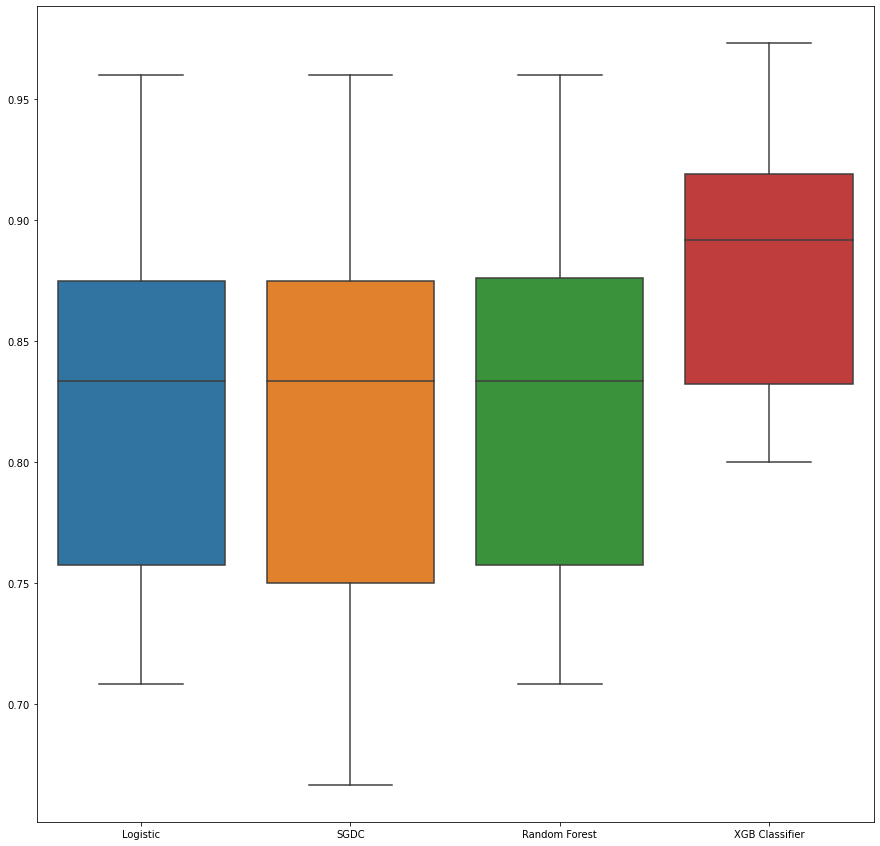

In [136]:
plt.figure(figsize = (15,15))
sns.boxplot(data = pd.DataFrame(model))

In [137]:
models = [log_improve,sgdc_improve,rdf_improve,xgb_improve]

* Precision cao => Recall thấp => có nhiều False negative => có nhiều người đủ điều kiện vay mà không được cho vay => mất doanh thu
* Precision thấp => Recall cao => có nhiều False positive => có nhiều người không điều kiện vay mà được cho vay => không đủ điều kiện trả 
* Vậy ta sẽ dùng chỉ số F1 để đánh giá

In [138]:
acc = []
for model in models:
    acc.append(accuracy_score(y_test,model.predict(x_test))*100)


In [139]:
f1 = []
for model in models:
    f1.append(f1_score(y_test,model.predict(x_test))*100)

In [140]:
cp = pd.DataFrame({"Accuracy":acc,"F1-Score":f1},index = {"Logistic Regression","SGD Classifier","Random Forest","XGB Classifier"})
cp

Accuracy   F1-Score
Random Forest        78.861789  85.869565
XGB Classifier       78.861789  85.869565
Logistic Regression  79.674797  85.875706
SGD Classifier       81.300813  87.150838

# Tổng kết các mô hình: 
* Vì mô hình XGBoost có hiệu suất cao nhất nên ta sẽ dùng mô hình XGBoost với F1_score = 0.87151 và Accuracy = 0.813

# Phân tích lỗi

* Ta thấy mô hình XGBooost có hiệu suất cao nhất. Do đó ta sẽ tạo ma trận nhầm lẫn dựa trên mô hình này

In [141]:
conn = confusion_matrix(y_test,xgb_improve.predict(x_test))

In [142]:
ConfusionMatrixDisplay(conn).plot()

In [143]:
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

* Dựa vào ma trận nhầm lẫn ta thấy tỉ lệ mẫu dương dự đoán đúng rất cao(334/8). Bên cạnh đó, mô hình khó phân biệt 1 nhãn là âm hoặc dương đối với nhãn âm, tỉ lệ `True Negative` và `False Positive` gần như không có sự khác biệt. Điều này xảy ra là do có thể tập nhãn không được cân bằng(có ít mẫu âm trong dữ liệu).